# Project Overview
- In this project, the objective is to develop a machine learning model capable of accurately predicting the compressive strength of concrete based on its constituent materials.

## Problem Statement
- Traditionally, predicting concrete strength depends on empirical formulas and extensive laboratory testing, which can be time-consuming and expensive. 
- The objective is to overcome these limitations by creating a machine learning model capable of predicting concrete strength more efficiently and accurately, thus providing valuable insights for optimizing concrete formulations and improving construction practices.

### Importing Necessary Libraries

In [1]:
# for dataframe manipulation and analysis
import pandas as pd
import numpy as np

# for data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 

# for warnings filtering
import warnings
warnings.filterwarnings('ignore')

# for data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,learning_curve,GridSearchCV

# for model building
from sklearn.linear_model import LinearRegression,Lasso,Ridge,SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost

# for model evaluation
from sklearn.metrics import r2_score,mean_squared_error

### Loading The Dataframe

In [2]:
data = pd.read_excel('Capstone Project.xlsx')
data.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


#### About the dataset
- The dataset consists of various concrete constituents such as cement, coarse aggregate, fine aggregate, water, slag, fly ash, age and superplasticizer content, along with the target variable, compressive strength of concrete.

### Create a test set

In [3]:
train_data,test_data = train_test_split(data,test_size = 0.2,random_state = 5,shuffle = True)

# Exploratory Data Analysis and Data cleaning

### Take a quick look at the Data

In [4]:
df = train_data.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824 entries, 784 to 867
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        824 non-null    float64
 1   slag          824 non-null    float64
 2   ash           824 non-null    float64
 3   water         824 non-null    float64
 4   superplastic  824 non-null    float64
 5   coarseagg     824 non-null    float64
 6   fineagg       824 non-null    float64
 7   age           824 non-null    int64  
 8   strength      824 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 64.4 KB


#### Analysis
- There are 824 records and 9 features(8 independent and 1 dependent feature) in the dataset.
- There is no missing values in the dataset.
- All columns are in continuous form.

## Visualizing the data to gain insights.

### Understanding Numerical features(Descriptive statistics)

In [6]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000
mean,281.409951,73.682767,54.205825,181.431189,6.186165,973.532282,773.190777,45.735437,35.842476
std,104.824040,86.714164,64.170512,21.500813,6.092503,78.050925,80.493994,63.697095,16.704277
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,4.570000
25%,192.000000,0.000000,0.000000,164.900000,0.000000,932.000000,728.975000,7.000000,23.797500
50%,273.900000,22.000000,0.000000,185.000000,6.250000,968.000000,780.050000,28.000000,33.955000
75%,350.000000,142.575000,118.300000,192.000000,10.200000,1029.400000,825.000000,56.000000,46.230000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


#### Analysis

- cement,slag,ash,age,strength feature may have outliers as mean and median are not same.
- There is no chance of outliers in lower whisker region in features slag,ash,superplastic as min and Q1 are equal.
- cement,slag,ash,superplastic,age may have outliers in upper whisker region.

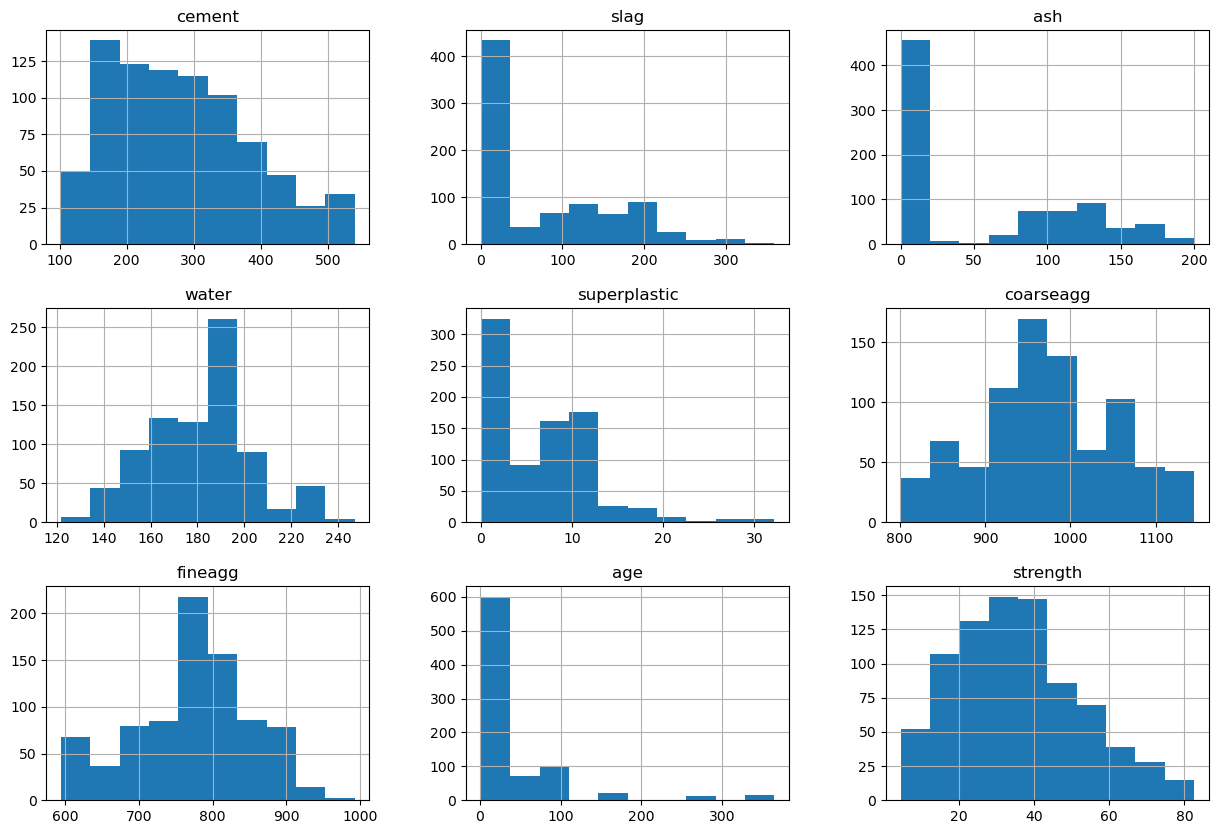

In [7]:
df.hist(figsize = (15,10))
plt.show()

#### Analysis
- These attributes have very different scales, so feature scaling is required.
- Many histograms are tail heavy, so there are chances of outliers.

### Custom Summary function for in depth EDA report

In [8]:
def custom_summary(mydf):
    col = []
    for i in mydf.columns:
        if mydf[i].dtype != object:
            col.append(i)
            
    result = pd.DataFrame(columns = col,index = ['datatype','count','mean','std','min','Q1','median','Q3','max','range',
                                                 'IQR','skew','kurt','skew_comment','kurt_comment','outlier_comment'])
    
    for i in result.columns:
        result.loc['datatype',i] = mydf[i].dtype
        result.loc['count',i] = mydf[i].count()    
        result.loc['mean',i] = round(mydf[i].mean(),2)    
        result.loc['std',i] = round(mydf[i].std(),2) 
        result.loc['min',i] = mydf[i].min()    
        result.loc['Q1',i] = mydf[i].quantile(0.25)   
        result.loc['median',i] = round(mydf[i].quantile(0.50),2)  
        result.loc['Q3',i] = mydf[i].quantile(0.75)    
        result.loc['max',i] = mydf[i].max()    
        result.loc['range',i] = mydf[i].max() - mydf[i].min()    
        result.loc['IQR',i] = round(mydf[i].quantile(0.75) - mydf[i].quantile(0.25),2)    
        result.loc['skew',i] = round(mydf[i].skew(),2)   
        result.loc['kurt',i] = round(mydf[i].kurt(),2)  
        
    # adding comment for skewness
        if result.loc['skew',i] <= -1:
            skew_label = 'Highly Negatively skewed'
        elif -1 < result.loc['skew',i] <= -0.5:
            skew_label = 'moderately Negatively skewed'
        elif -0.5 < result.loc['skew',i] <= 0:
            skew_label = 'Approximately Normally distributed(-ve)'
        elif 0 < result.loc['skew',i] <= 0.5:
            skew_label = 'Approximately Normally distributed(+ve)'
        elif 0.5 < result.loc['skew',i] <= 1:
            skew_label = 'moderately positively skewed'
        elif result.loc['skew',i] > 1:
            skew_label = 'Highly positively skewed'
        else:
            skew_label = 'error'
        result.loc['skew_comment',i] = skew_label
        
    # adding comment for kurtosis
        if result.loc['kurt',i] <= -1:
            kurt_label = 'highly platykurtic'
        elif -1 < result.loc['kurt',i] <= -0.5:
            kurt_label = 'moderately platykurtic'
        elif -0.5 < result.loc['kurt',i] <= 0.5:
            kurt_label = 'mesokurtic'
        elif 0.5 < result.loc['kurt',i] <= 1:
            kurt_label = 'moderately leptokurtic'
        elif result.loc['kurt',i] > 1:
            kurt_label = 'Highly leptokurtic'
        else:
            kurt_label = 'error'
        result.loc['kurt_comment',i] = kurt_label
    
    # adding comment for outliers
        LW = result.loc['Q1',i] - 1.5 * result.loc['IQR',i]
        UW = result.loc['Q3',i] + 1.5 * result.loc['IQR',i]
        
        if len([x for x in mydf[i] if x < LW or x > UW]) > 0:
            outlier_label = 'Have outliers'
        else:
            outlier_label = 'No outliers'
        result.loc['outlier_comment',i] = outlier_label

    return result

In [9]:
custom_summary(df)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
datatype,float64,float64,float64,float64,float64,float64,float64,int64,float64
count,824,824,824,824,824,824,824,824,824
mean,281.41,73.68,54.21,181.43,6.19,973.53,773.19,45.74,35.84
std,104.82,86.71,64.17,21.5,6.09,78.05,80.49,63.7,16.7
min,102.0,0.0,0.0,121.8,0.0,801.0,594.0,1,4.57
Q1,192.0,0.0,0.0,164.9,0.0,932.0,728.975,7.0,23.7975
median,273.9,22.0,0.0,185.0,6.25,968.0,780.05,28.0,33.96
Q3,350.0,142.575,118.3,192.0,10.2,1029.4,825.0,56.0,46.23
max,540.0,359.4,200.1,247.0,32.2,1145.0,992.6,365,82.6
range,438.0,359.4,200.1,125.2,32.2,344.0,398.6,364,78.03


#### Analysis
- Slag,water,superpalstic,fineagg,age features have outliers.

## Looking for correlations

### Multivariate Analysis using regression

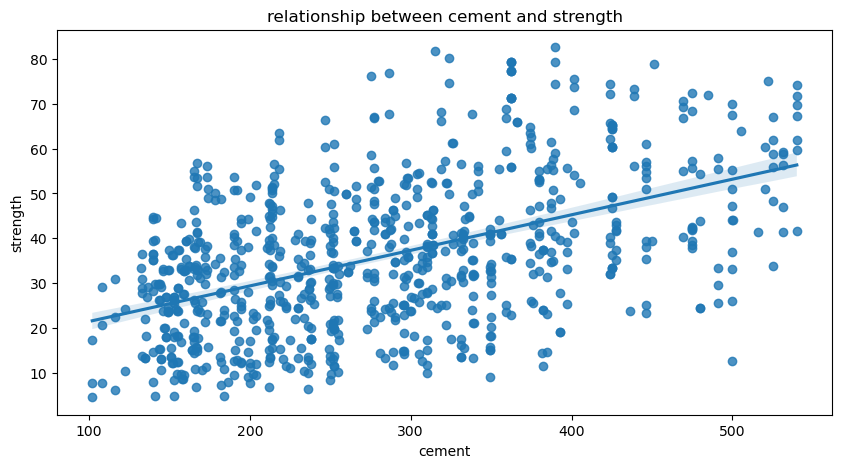

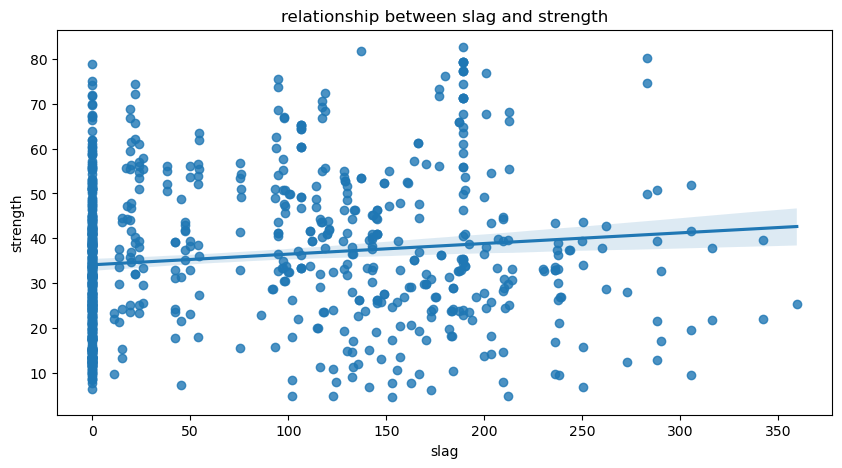

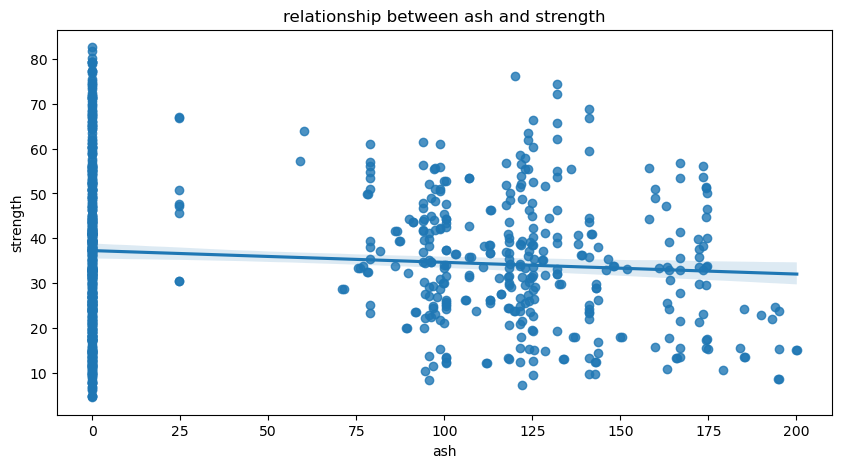

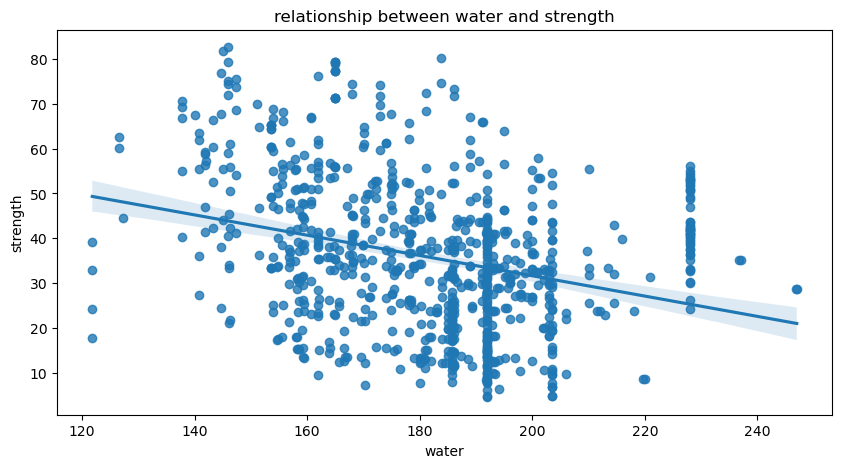

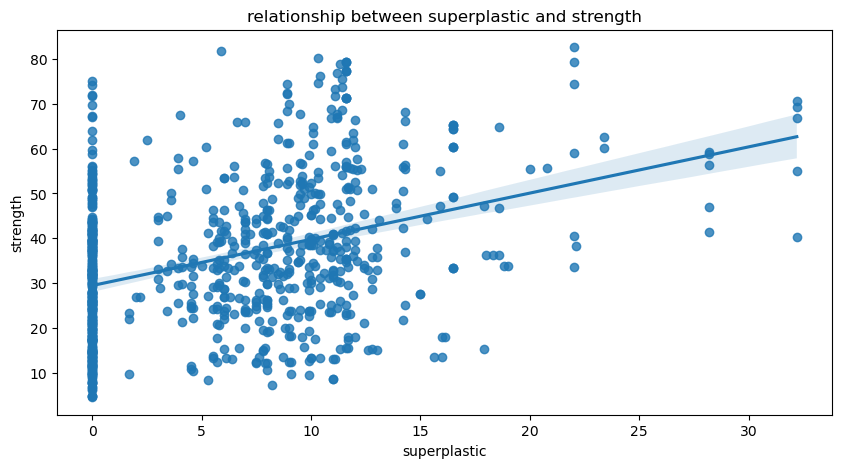

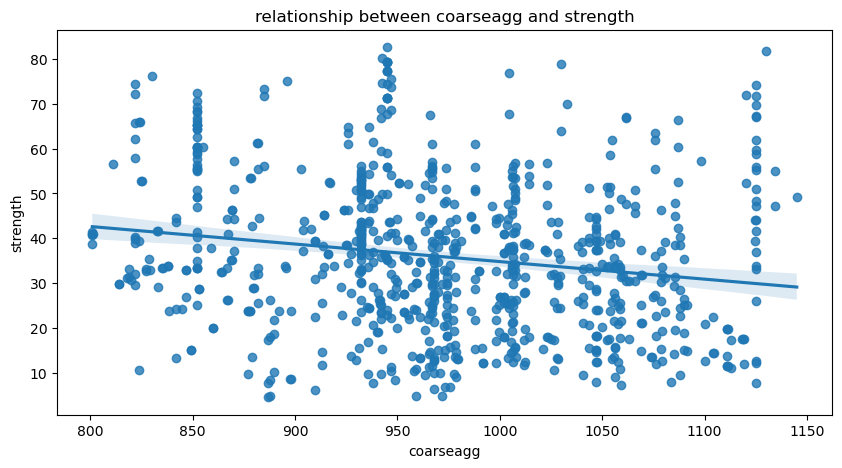

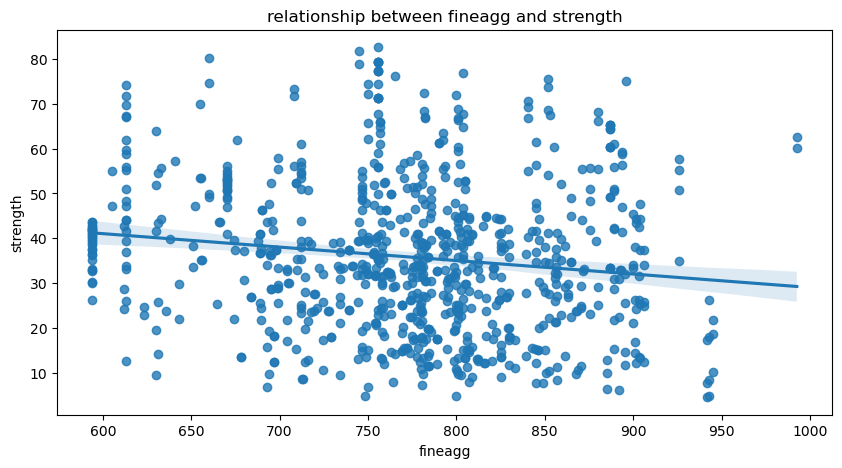

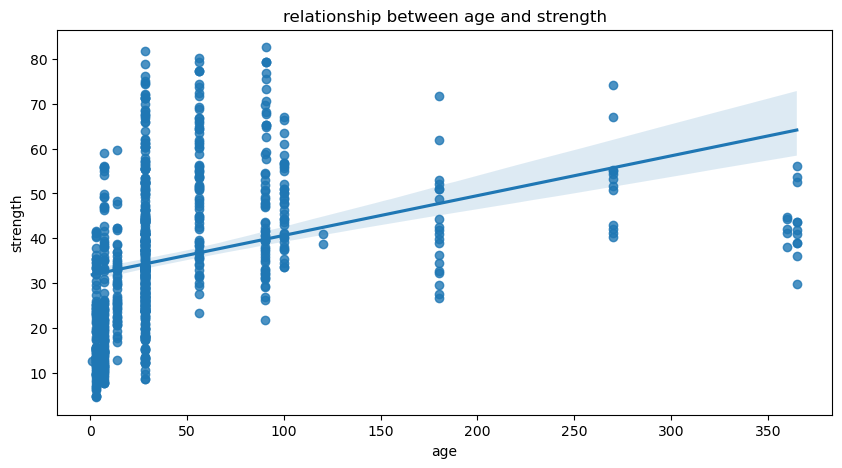

In [10]:
for col in df.drop('strength',axis = 1).columns:
    f,ax = plt.subplots(1,1,figsize = (10,5))
    sns.regplot(df[col],df['strength']).set_title(f'relationship between {col} and strength')

#### Analysis

* cement and Strength have a strong positive correlation.
* Slag and strength have a mild positive correlation.
* Ash and strength have a mild negative correlation.
* water and strength have a strong negative correlation.
* Superplastic and strength have a strong positive correlation.
* coarseagg and strength have a mild negative correlation.
* fineagg and strength have a mild negative correlation.
* Age and strength have a strong positive correlation.

## Feature engineering

### Experimenting with attribute combination

In [11]:
df['wc_ratio'] = df['water']/df['cement']

In [12]:
df.corr()['strength'].sort_values(ascending = False)

strength        1.000000
cement          0.497587
superplastic    0.375872
age             0.337988
slag            0.123253
ash            -0.100562
fineagg        -0.144570
coarseagg      -0.182882
water          -0.291171
wc_ratio       -0.497399
Name: strength, dtype: float64

so new added feature is more correlated with the target variable.

## Summary of EDA 
- There are no missing values in the dataset.
- All columns are in categorical form.
- some features have outliers.
- new added features can be useful.
- Features have different scales.

## Preparing the data for ML model

### Seperating independent and target variable.

In [13]:
X_train = train_data.drop('strength',axis = 1)
y_train = train_data['strength']

### Data cleaning
#### Preparation steps to do
- Add new feature.
- Treat outliers.
- Feature scaling.

### Adding new features

In [14]:
X_train['wc_ratio'] = X_train['water']/X_train['cement']

### Outliers Treatment

In [15]:
def replace_outliers(mydf,col,method = 'quartile',strategy = 'median'):
    if method == 'quartile':
        Q1 = mydf[col].quantile(0.25)
        Q3 = mydf[col].quantile(0.75)
        mean = mydf[col].mean()
        IQR = Q3 - Q1
        LW = Q1 - 1.5 * IQR
        UW = Q3 + 1.5 * IQR
    elif method == 'std':
        mean = mydf[col].mean()
        std = mydf[col].std()
        LW = mean - 2 * std
        UW = mean + 2 * std
    else:
        print('pass a correct method')
        
    # printing outliers
    outliers = mydf.loc[(mydf[col] < LW) | (mydf[col] > UW),col]
    outliers_density = round(len(outliers)/len(mydf),2)
    if len(outliers) == 0:
        print(f'feature {col} does not have outliers')
    else:
        print(f'feature {col} have outliers')
        print(f'Total number of outliers in {col} is {len(outliers)}')
        print(f'outliers percentage in {col} is {outliers_density * 100}%')
         
    if outliers_density * 100 > 2.0:
        if strategy =='median':
            mydf.loc[(mydf[col] < LW),col] = Q1
            mydf.loc[(mydf[col] > UW),col] = Q3
        elif strategy == 'mean':
            mydf.loc[mydf[col] < LW,col] = mean
            mydf.loc[mydf[col] > UW,col] = mean
        else:
            print('pass a correct strategy')
        
    return mydf     

In [16]:
def ott_plots(mydf,col):
    f,(ax1,ax2) = plt.subplots(1,2,figsize = (15,5))
    sns.boxplot(mydf[col],ax = ax1)
    ax1.set_xlabel('values')
    ax1.set_ylabel('boxplot')
    ax1.set_title(col + ' boxplot')
    mydf_out = replace_outliers(mydf,col)
    sns.boxplot(mydf_out[col],ax = ax2)
    ax2.set_xlabel('values')
    ax2.set_ylabel('boxplot')
    ax2.set_title(col + ' boxplot')
    plt.show()

feature cement does not have outliers


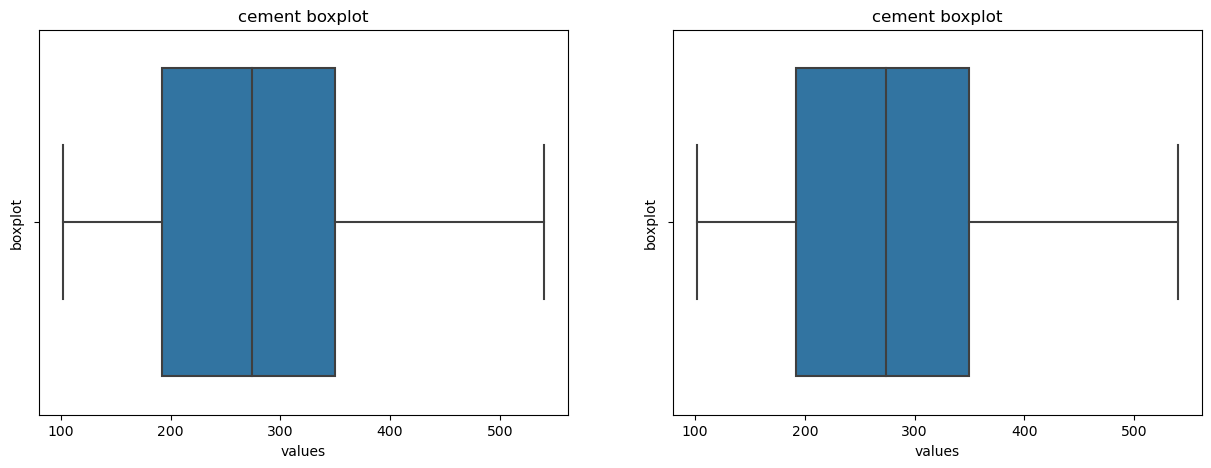

feature slag have outliers
Total number of outliers in slag is 1
outliers percentage in slag is 0.0%


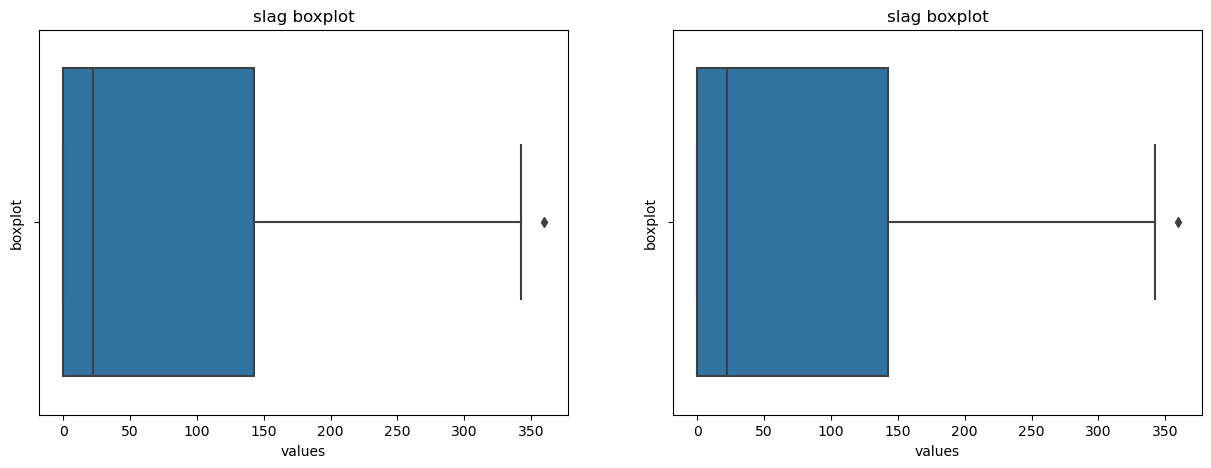

feature ash does not have outliers


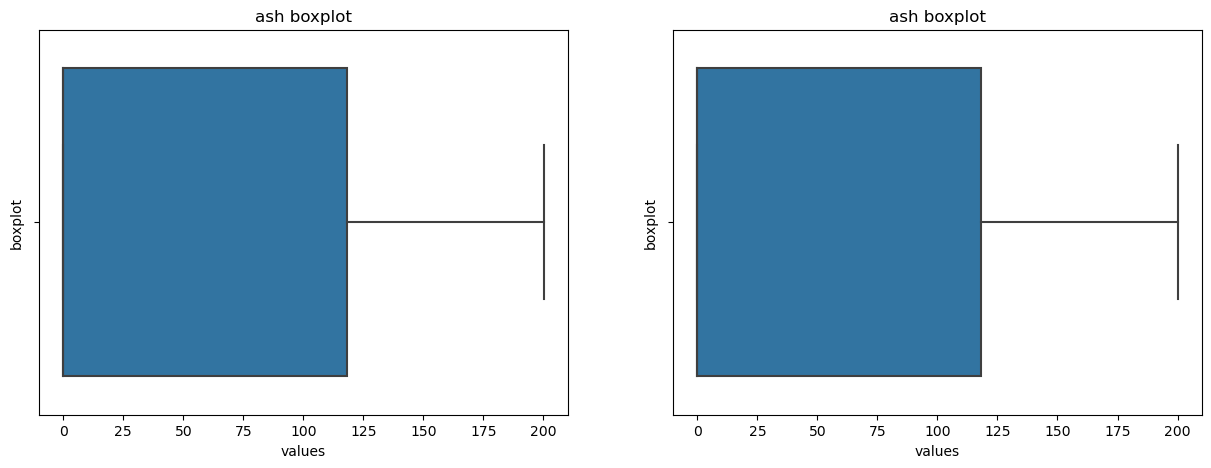

feature water have outliers
Total number of outliers in water is 8
outliers percentage in water is 1.0%


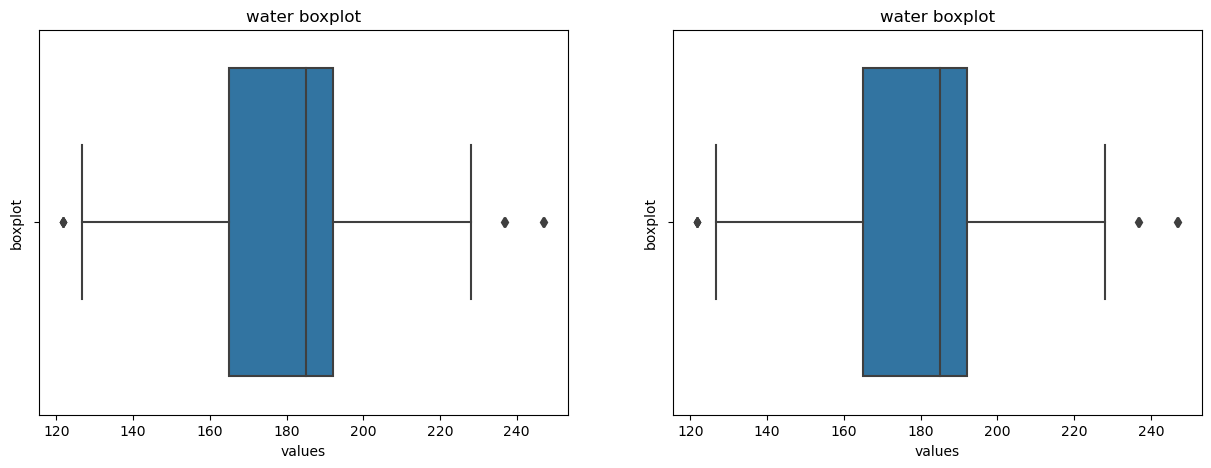

feature superplastic have outliers
Total number of outliers in superplastic is 10
outliers percentage in superplastic is 1.0%


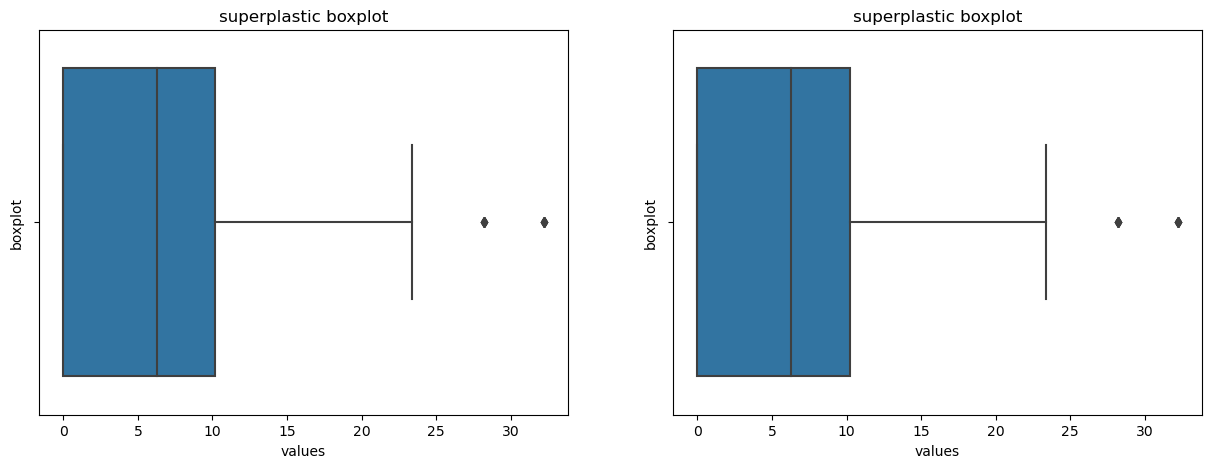

feature coarseagg does not have outliers


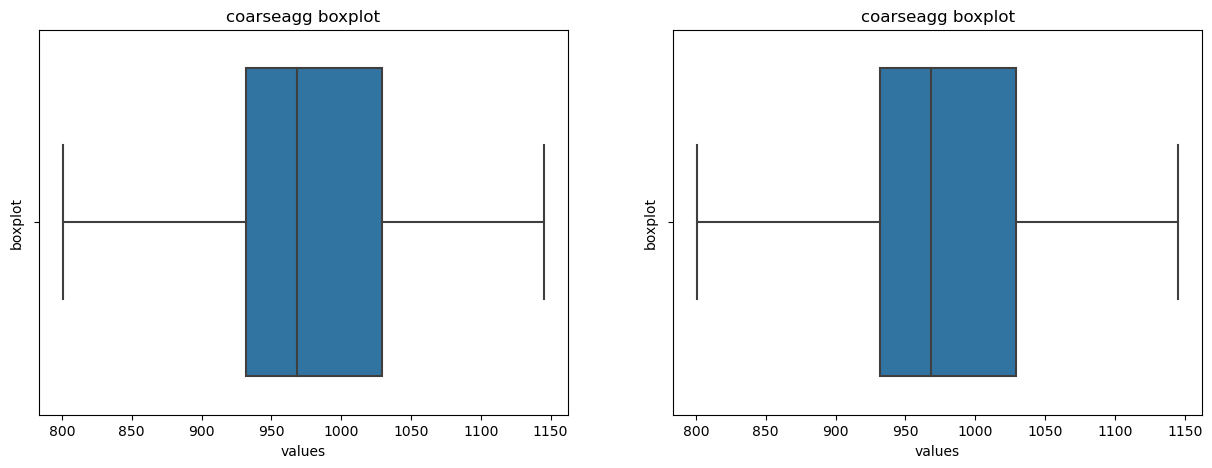

feature fineagg have outliers
Total number of outliers in fineagg is 2
outliers percentage in fineagg is 0.0%


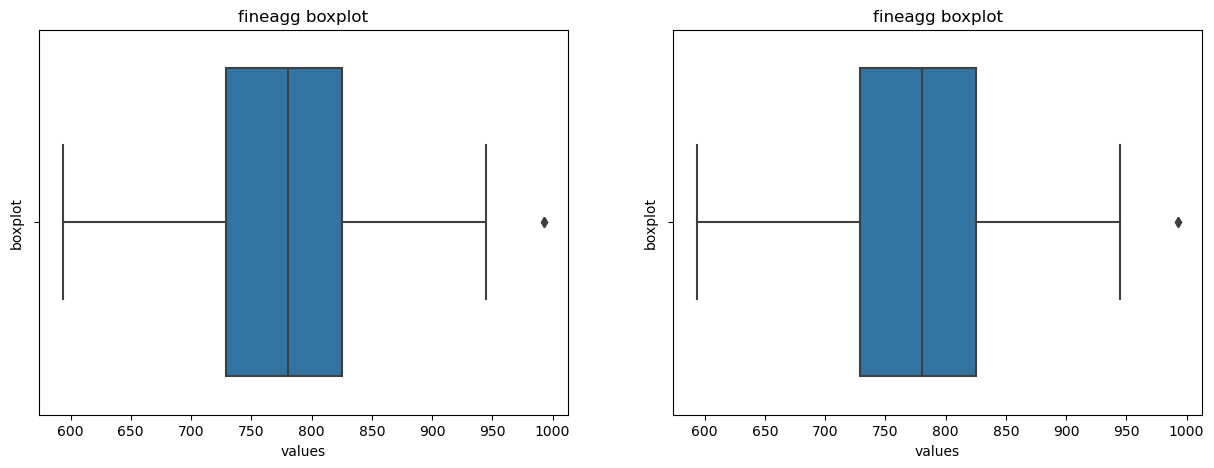

feature age have outliers
Total number of outliers in age is 48
outliers percentage in age is 6.0%


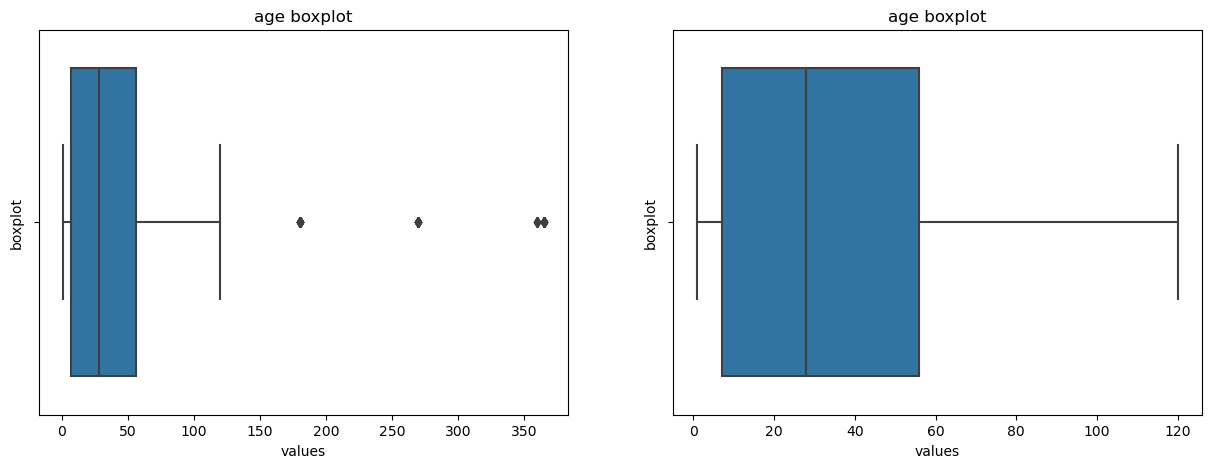

feature wc_ratio have outliers
Total number of outliers in wc_ratio is 13
outliers percentage in wc_ratio is 2.0%


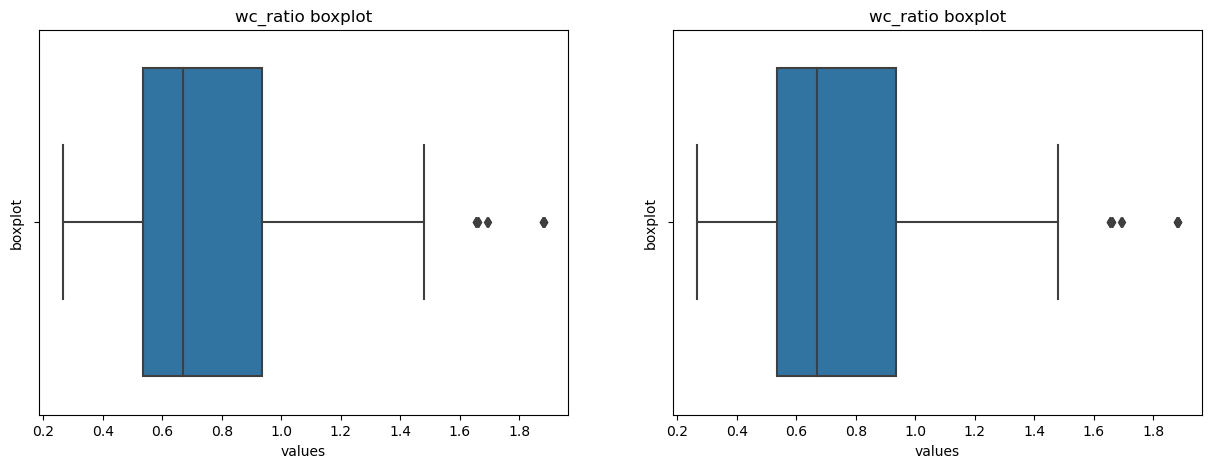

In [17]:
for col in X_train.columns:
    ott_plots(X_train,col)

## Feature Scaling

In [18]:
std_scaler = StandardScaler()
scaled_data = std_scaler.fit_transform(X_train)
X_train = pd.DataFrame(scaled_data,columns = X_train.columns)

## Model Building

### Training and evaluating different models

In [19]:
def model_builder(model_name,estimator,x,y):
    estimator.fit(x,y)
    y_pred = estimator.predict(x)
    accuracy = r2_score(y,y_pred)
    rmse = np.sqrt(mean_squared_error(y,y_pred))
    return [model_name,accuracy,rmse]

In [20]:
def master_model(x,y):
    result = pd.DataFrame(columns = ['Model name','accuracy','rmse'])
    result.loc[len(result)] = model_builder('Linear regression',LinearRegression(),x,y)   
    result.loc[len(result)] = model_builder('Decision tree',DecisionTreeRegressor(),x,y)    
    result.loc[len(result)] = model_builder('KNN',KNeighborsRegressor(),x,y)    
    result.loc[len(result)] = model_builder('SVM',SVR(),x,y)    
    result.loc[len(result)] = model_builder('Random forest',RandomForestRegressor(),x,y)    
    result.loc[len(result)] = model_builder('Adaboost',AdaBoostRegressor(),x,y)    
    result.loc[len(result)] = model_builder('Gradient boost',GradientBoostingRegressor(),x,y)    
    result.loc[len(result)] = model_builder('XG boost',XGBRegressor(),x,y) 
    return result.sort_values(by = 'accuracy',ascending = False)

In [21]:
master_model(X_train,y_train)

,Model name,accuracy,rmse
1,Decision tree,0.996018,1.053496
7,XG boost,0.995401,1.132168
4,Random forest,0.984831,2.056078
6,Gradient boost,0.951045,3.693700
2,KNN,0.877055,5.853557
5,Adaboost,0.824314,6.997336
3,SVM,0.748326,8.374970
0,Linear regression,0.743606,8.453136


## Cross validation

In [22]:
def Kfoldcv(x,y,fold = 10):
    score_lr = cross_val_score(LinearRegression(),x,y,scoring = 'neg_mean_squared_error',cv = fold)
    cv_score_lr = np.sqrt(-score_lr)
    score_dt = cross_val_score(DecisionTreeRegressor(),x,y,scoring = 'neg_mean_squared_error',cv = fold) 
    cv_score_dt = np.sqrt(-score_dt)
    score_knn = cross_val_score(KNeighborsRegressor(),x,y,scoring = 'neg_mean_squared_error',cv = fold)  
    cv_score_knn = np.sqrt(-score_knn)
    score_svr = cross_val_score(SVR(kernel = 'linear'),x,y,scoring = 'neg_mean_squared_error',cv = fold)
    cv_score_svr = np.sqrt(-score_svr)
    score_rf = cross_val_score(RandomForestRegressor(),x,y,scoring = 'neg_mean_squared_error',cv = fold)
    cv_score_rf = np.sqrt(-score_rf)
    score_ab = cross_val_score(AdaBoostRegressor(),x,y,scoring = 'neg_mean_squared_error',cv = fold) 
    cv_score_ab = np.sqrt(-score_ab)
    score_gb = cross_val_score(GradientBoostingRegressor(),x,y,scoring = 'neg_mean_squared_error',cv = fold) 
    cv_score_gb = np.sqrt(-score_gb)
    score_xgb = cross_val_score(XGBRegressor(),x,y,scoring = 'neg_mean_squared_error',cv = fold) 
    cv_score_xgb = np.sqrt(-score_xgb)
    
    model_names = ['Linear regression','Decision tree','KNN','SVM','Random forest','Adaboost',
                  'Gradient boost','XG boost']
    scores = [cv_score_lr,cv_score_dt,cv_score_knn,cv_score_svr,cv_score_rf,cv_score_ab,cv_score_gb,cv_score_xgb]
    
    result = []
    for i in range(len(model_names)):
        scores_mean = np.mean(scores[i])
        scores_std = np.std(scores[i])
        model = model_names[i]
        result.append([model,scores_mean,scores_std])
    
    kfolddf = pd.DataFrame(result,columns = ['Model name','cv_mean','cv_std'])
    return kfolddf.sort_values(by = ['cv_mean','cv_std'])

In [23]:
Kfoldcv(X_train,y_train)

,Model name,cv_mean,cv_std
7,XG boost,4.394579,0.847182
4,Random forest,5.010831,0.623042
6,Gradient boost,5.063315,0.705649
1,Decision tree,6.489909,0.540499
2,KNN,7.463069,0.699018
5,Adaboost,7.708294,0.589323
0,Linear regression,8.521812,0.687026
3,SVM,8.541535,0.697072


##  Training model analysis

### Learning curve analysis

In [24]:
def learn_curve(model_name,estimator,x,y):
    train_size,train_score,test_score = learning_curve(estimator,x,y,cv = 10,scoring = 'neg_mean_squared_error',
                                                       shuffle = True,random_state = 5,
                                                      train_sizes = [1,100,200,300,400,500,600,741])
    train_score_mean = np.mean(np.sqrt(-train_score),axis = 1)
    test_score_mean = np.mean(np.sqrt(-test_score),axis = 1)
    plt.plot(train_size,train_score_mean,c = 'red')
    plt.plot(train_size,test_score_mean,c = 'blue')
    plt.xlabel('samples size')
    plt.ylabel('scores')
    plt.title('learning curve for '+ model_name)
    plt.legend(('training score','testing score'))
    plt.ylim(0,15)
    plt.show()

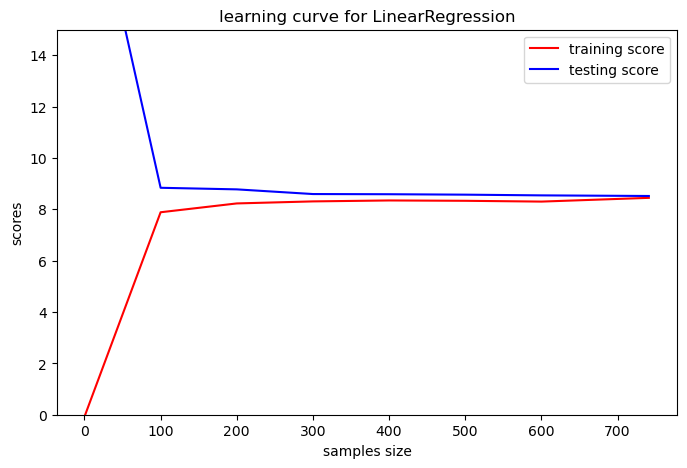

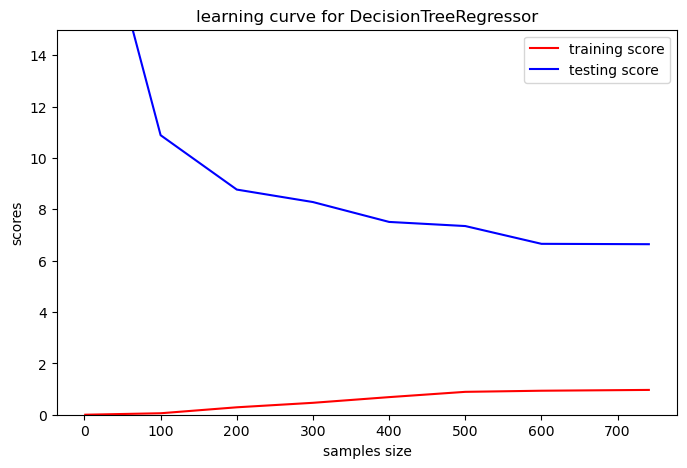

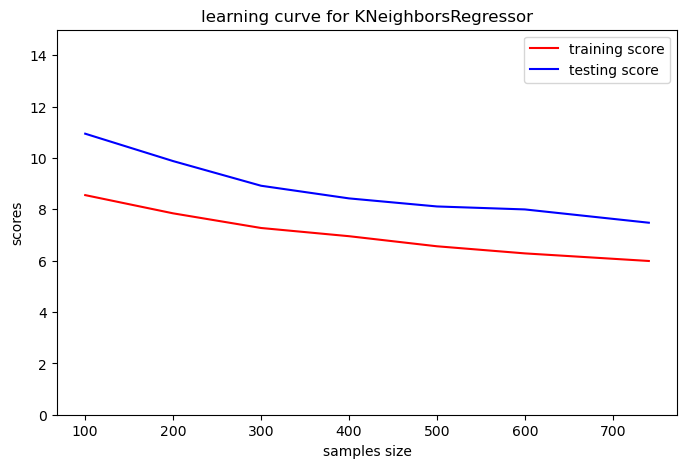

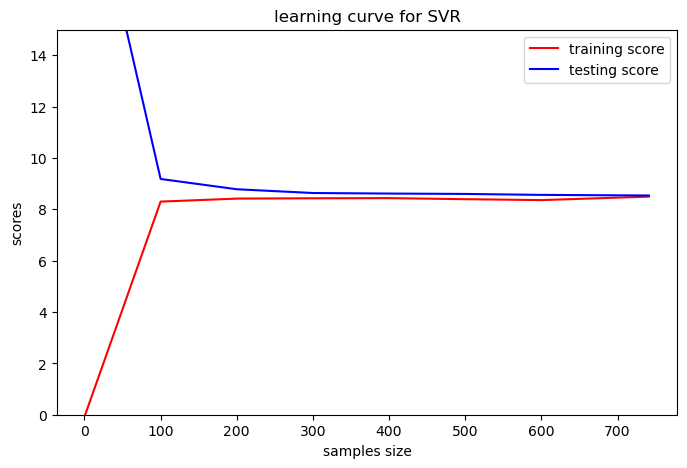

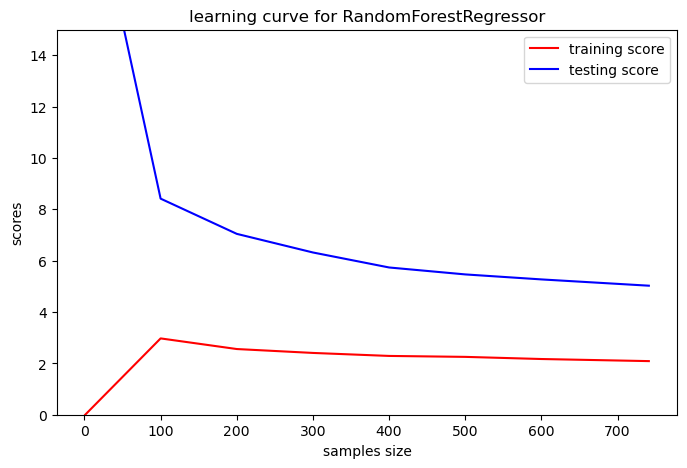

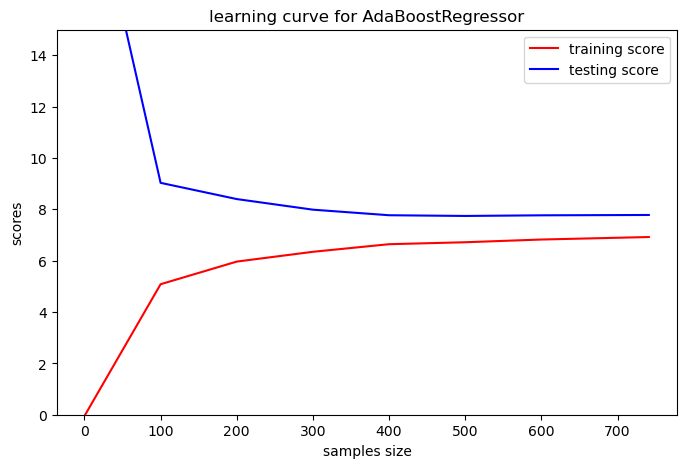

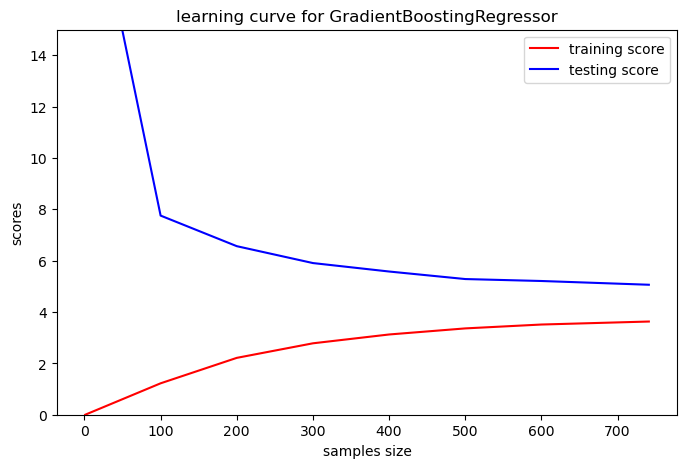

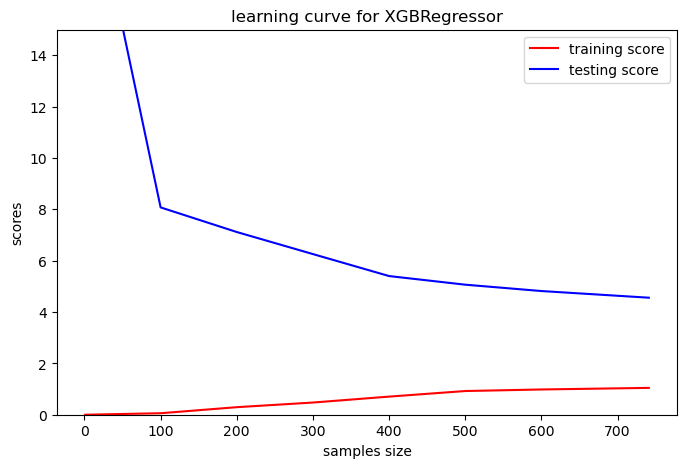

In [25]:
model_names = [LinearRegression(),DecisionTreeRegressor(),KNeighborsRegressor(),SVR(kernel = 'linear'),
              RandomForestRegressor(),AdaBoostRegressor(),GradientBoostingRegressor(),XGBRegressor()]

for model in model_names:
    plt.figure(figsize = (8,5))
    learn_curve(type(model).__name__,model,X_train,y_train)

### Conclusions(after cross validation and from learning curve).
- Linear regression,KNN,SVR,Ada boost model has high bias and low variance.They are underfitting the dataset.
- Decision Tree is highly overfitting the dataset.
- Random Forest, Gradient Boosting and Xgboost are also overfitting the dataset. but they have low bias and performing better compared to other models(but still they have high variance).Since more training data cannot be added,regularizing this model can reduce the generalization error.

Lets select XG boost for hyperparameter tuning.

## Hyperparameter Tuning

### Fine tuning XGboost

In [26]:
# parameter grid
param_xgb = {'n_estimators' : [900,1000,1100],'max_depth' : [1,3,5],'eta' : [0.11,0.13,0.15],
              'alpha' : [1,3,5]}

# creating model object   
grid_xgb = GridSearchCV(XGBRegressor(),param_xgb,cv = 10,scoring = 'neg_mean_squared_error',
                              return_train_score = True)

# model fitting
grid_xgb.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estima

In [27]:
grid_xgb.best_params_

{'alpha': 3, 'eta': 0.11, 'max_depth': 3, 'n_estimators': 1100}

In [28]:
xgb_cv = grid_xgb.cv_results_
for mean_score,param in zip(xgb_cv['mean_test_score'],xgb_cv['params']):
    print(np.sqrt(-mean_score),param)

5.4593891670055825 {'alpha': 1, 'eta': 0.11, 'max_depth': 1, 'n_estimators': 900}
5.4256353311288255 {'alpha': 1, 'eta': 0.11, 'max_depth': 1, 'n_estimators': 1000}
5.397690985952805 {'alpha': 1, 'eta': 0.11, 'max_depth': 1, 'n_estimators': 1100}
4.110291046182787 {'alpha': 1, 'eta': 0.11, 'max_depth': 3, 'n_estimators': 900}
4.0981892391730534 {'alpha': 1, 'eta': 0.11, 'max_depth': 3, 'n_estimators': 1000}
4.088546781874163 {'alpha': 1, 'eta': 0.11, 'max_depth': 3, 'n_estimators': 1100}
4.16944181018514 {'alpha': 1, 'eta': 0.11, 'max_depth': 5, 'n_estimators': 900}
4.16944181018514 {'alpha': 1, 'eta': 0.11, 'max_depth': 5, 'n_estimators': 1000}
4.16944181018514 {'alpha': 1, 'eta': 0.11, 'max_depth': 5, 'n_estimators': 1100}
5.401611690545008 {'alpha': 1, 'eta': 0.13, 'max_depth': 1, 'n_estimators': 900}
5.369935324228343 {'alpha': 1, 'eta': 0.13, 'max_depth': 1, 'n_estimators': 1000}
5.346759298443791 {'alpha': 1, 'eta': 0.13, 'max_depth': 1, 'n_estimators': 1100}
4.126294028941376 {'

In [29]:
import joblib
joblib.dump(grid_xgb.best_estimator_,'strength.pkl')

['strength.pkl']

In [30]:
model = joblib.load('strength.pkl')

## Feature importance

In [31]:
xgb = XGBRegressor(eta = 0.11, max_depth = 3, n_estimators = 1100,alpha = 3)
xgb.fit(X_train,y_train)

XGBRegressor(alpha=3, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.11, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1100, n_jobs=None,
             num_parallel_tree=None, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

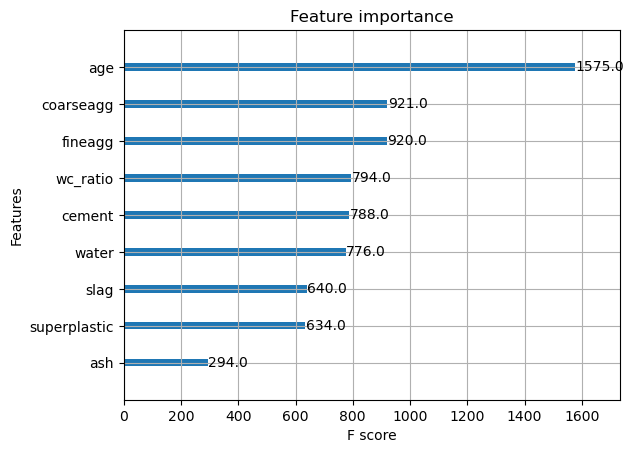

In [32]:
import xgboost
xgboost.plot_importance(xgb)

#### Insights and Interpretation:
- The age was found to be the most important feature in determining concrete strength, followed by Coarseagg,fineagg.

## Testing on test data

### Transforming

In [33]:
X_test = test_data.drop('strength',axis = 1)
y_test = test_data['strength']

In [34]:
X_test['wc_ratio'] = X_test['water']/X_test['cement']
X_test = std_scaler.transform(X_test)

### Model prediction on test set

In [35]:
y_pred_test = model.predict(X_test)
np.sqrt(mean_squared_error(y_test,y_pred_test))

4.563238910213793

In [36]:
r2_score(y_test,y_pred_test)

0.9254359776608214

### Conclusion:

- In this project,a machine learning model is developed to predict the compressive strength of concrete based on its constituent materials. Through data analysis, feature engineering, and model training, an RMSE of 4.56 N/mm² is achieved, indicating a reasonable level of accuracy in the predictions.